In [2]:
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [13]:
# hyper parameter
random_seed = 42
learning_rate = 0.001
batch_size = 32
num_epochs = 15
img_size = 32
num_classes = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
# 정확도를 구하는 함수와 손길을 시각화 하는 function 정의
def get_accuracy(model, data_loader, device):
    correct_pred = 0
    n = 0
    with torch.no_grad():
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)
            
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)
            
            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()
        
    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    plt.style.use("seaborn")
    
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel="Epochs",
           ylabel="loss")
    ax.legend()
    fig.show()
    plt.style.use('default')

In [5]:
# training data에 사용되는 helper 함수 정의하기
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
        
        # 순전파
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)
        
        # 역전파
        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [16]:
# validation data에 사용되는 검증 함수 정의하기
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)
        
        # 순전파와 손실함수 기록
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)
    
    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [17]:
# 훈련하는 반복문 정의하기
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    
    # model 학습하기
    for epoch in range(0, epochs):
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss) 
        
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)
            
        if epoch % print_every == (print_every - 1):
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            
            print(f'{datetime.now().time().replace(microsecond=0)} ---'
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
            
    plot_losses(train_losses, valid_losses)
    return model, optimizer, (train_losses, valid_losses)

Text(0.5, 0.98, 'MNIST Dataset - preview')

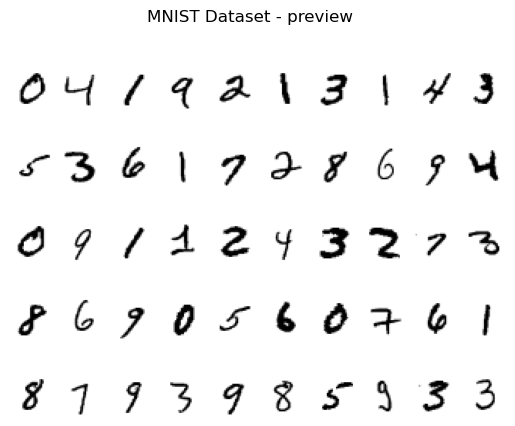

In [18]:
# data 정의하기
trans = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

train_dataset = datasets.MNIST(root='../data/',
                               train=True,
                               transform=trans,
                               download=True)

valid_dataset = datasets.MNIST(root='../data/',
                               train=False,
                               transform=trans)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=False)

row_img = 10
n_rows = 5

fig = plt.figure()

for index in range(1, row_img * n_rows + 1):
    plt.subplot(n_rows, row_img, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview')

In [19]:
# LeNet-5 클래스 정의하기
class LeNet5(nn.Module):
    
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(6, 16, 5, 1),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(16, 120, 5, 1),
            nn.Tanh()
        )
    
        self.classifier = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, n_classes),
        )
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [20]:
torch.manual_seed(random_seed)

model = LeNet5(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

13:29:24 ---Epoch: 0	Train loss: 0.2290	valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
13:29:52 ---Epoch: 1	Train loss: 0.0762	valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
13:30:21 ---Epoch: 2	Train loss: 0.0550	valid loss: 0.0542	Train accuracy: 98.58	Valid accuracy: 98.40
13:30:50 ---Epoch: 3	Train loss: 0.0434	valid loss: 0.0484	Train accuracy: 99.08	Valid accuracy: 98.49
13:31:19 ---Epoch: 4	Train loss: 0.0345	valid loss: 0.0442	Train accuracy: 99.19	Valid accuracy: 98.74
13:31:47 ---Epoch: 5	Train loss: 0.0301	valid loss: 0.0445	Train accuracy: 99.26	Valid accuracy: 98.63
13:32:15 ---Epoch: 6	Train loss: 0.0244	valid loss: 0.0446	Train accuracy: 99.43	Valid accuracy: 98.64
13:32:43 ---Epoch: 7	Train loss: 0.0219	valid loss: 0.0457	Train accuracy: 99.54	Valid accuracy: 98.65
13:33:11 ---Epoch: 8	Train loss: 0.0208	valid loss: 0.0504	Train accuracy: 99.42	Valid accuracy: 98.53
13:33:39 ---Epoch: 9	Train loss: 0.0167	valid loss: 0.0473	Train accuracy

C:\Users\ROBOTICS\AppData\Local\Temp\ipykernel_11148\991246141.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
C:\Users\ROBOTICS\AppData\Local\Temp\ipykernel_11148\991246141.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


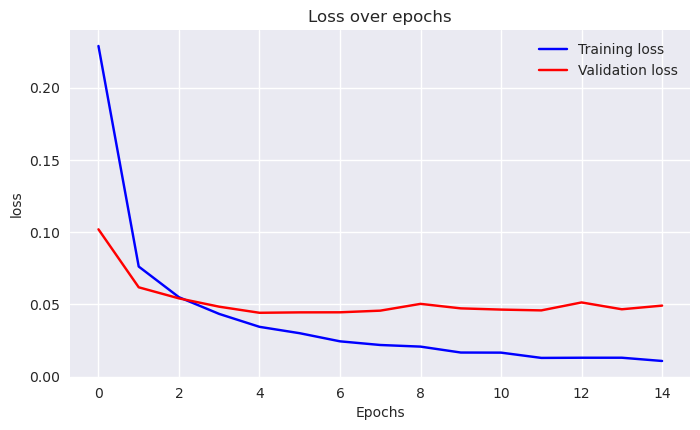

In [21]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader,
                                    valid_loader, num_epochs, device)